### Load packages
First we need to load the python packages that are required to perform the analysis

In [18]:
%matplotlib inline

import os
import rasterio
import numpy 
import pandas
import scipy.io # to load the matlab files

import matplotlib.pyplot as plt

from DamageScanner import DamageScanner # the tool to estimate the losses

data_path = os.path.join('..','Data')

### Set paths to data and load initial data

All the data is stored in the *Data* folder, so we are creating paths to load data from that folder. We will create a dictionary with the depth-damage information required to do the analysis.

In [47]:
# function to load DDM data
def read_DDM_input(DDM_data_path):
    DDM_data = {}
    DDM_data['Curves_structure'] = pandas.read_excel(DDM_data_path,sheet_name='curves_structure').values
    DDM_data['Curves_content'] = pandas.read_excel(DDM_data_path,sheet_name='curves_content').values
    DDM_data['MaxDam_structure'] = pandas.read_excel(DDM_data_path,sheet_name='maxdam_structure').values
    DDM_data['MaxDam_content'] = pandas.read_excel(DDM_data_path,sheet_name='maxdam_content').values  
    DDM_data['Landuse_names'] = dict(pandas.read_excel(DDM_data_path,sheet_name='landuse_list').values)  
    
    return DDM_data

In [48]:
inundation_maps = scipy.io.loadmat(os.path.join(data_path,'Waterdepth_current.mat')) # the inundation files for the current situation
landuse_map = os.path.join(data_path,'landuse.asc') # the land-use map
DDM_data = read_DDM_input(os.path.join(data_path,'DDM_data.xlsx'))

### Specify for which return period we want to estimate damages

The return periods are 1/10,1/100,1/1000,1/2000,1/4000,1/10000

In [49]:
return_period = 100

### Run the DamageScanner. We run it for both the structure and the content

In [61]:
# run the DamageScanner for the building structures
damage_structure,damagebin_structure = DamageScanner(landuse_map,inundation_maps['a0_{}'.format(return_period)],DDM_data['Curves_structure'],
                                                     DDM_data['MaxDam_structure'])

# run the DamageScanner for the content
damage_content,damagebin_content = DamageScanner(landuse_map,inundation_maps['a0_{}'.format(return_period)],DDM_data['Curves_content'],
                                                     DDM_data['MaxDam_content'])
# summarize both
damage_total = damage_content+damage_structure
damagebin_total  = pandas.DataFrame(pandas.concat([pandas.DataFrame(damagebin_structure['losses']), pandas.DataFrame(damagebin_content['losses'])], axis=1).fillna(0).sum(axis=1),columns=['losses'])
damagebin_total = pandas.concat([damagebin_total,damagebin_structure[['area','avg_depth']]],axis=1)
damagebin_total.index = damagebin_total.index.astype(int)
damagebin_total.index = damagebin_total.index.map(DDM_data['Landuse_names'])

#print output
print('{} Euro damage for a 1/{} flood event'.format(damage_total,return_period))

10172619.014999999 Euro damage for a 1/100 flood event


### Create a figure of the total damage per land use

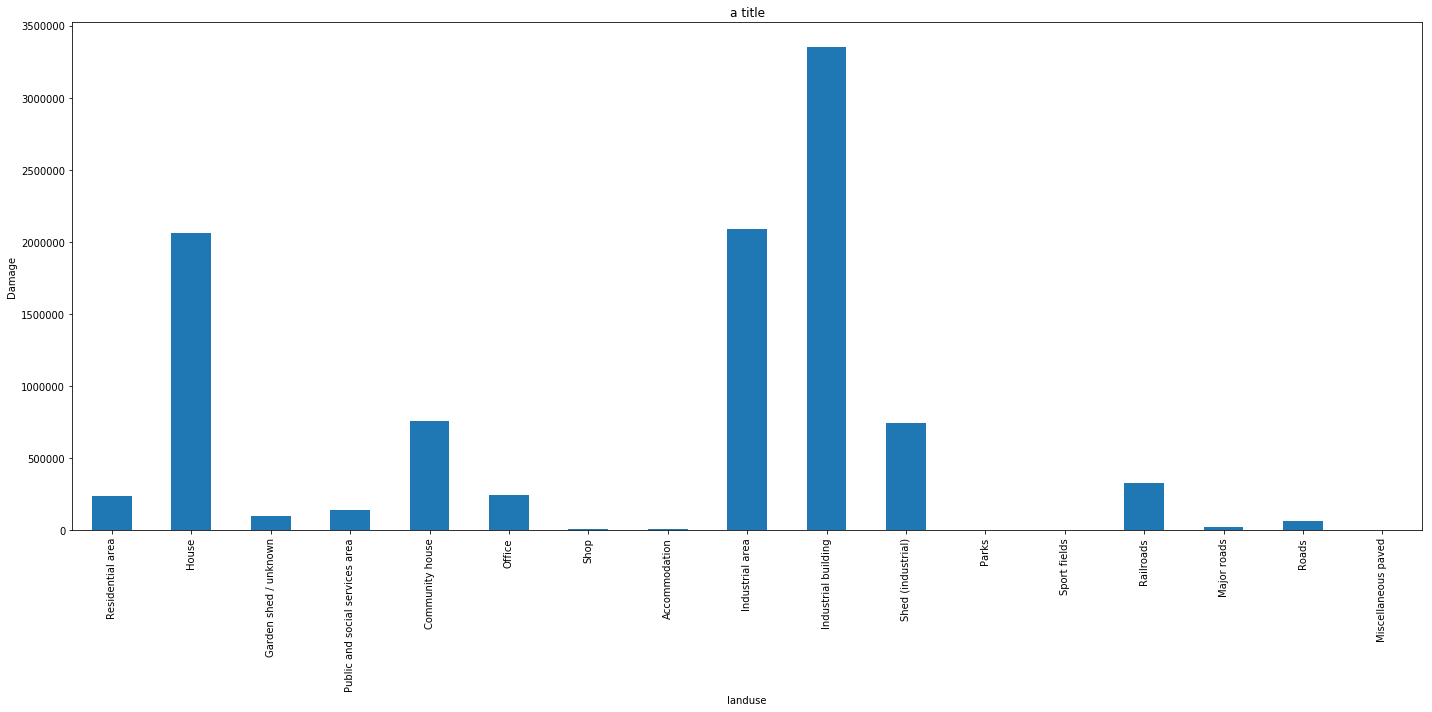

In [91]:
#you may consider only plotting the land-use classes that have a value greater 
#than zero. If so, remove the hashtag from the line below.
#damagebin_total = damagebin_total[damagebin_total.losses != 0]

plt.figure(figsize=(20,10))
plt.xticks(rotation=90) # add configurations
plt.xlabel('Landuse') # add configurations
plt.ylabel('Damage') # add configurations

plt.yticks() # add configurations
plt.xticks() # add configurations

plt.title('a title') # add configurations

damagebin_total['losses'].plot(kind='bar') # add configurations such as color or lining

plt.tight_layout()
output_path = os.path.join(data_path,'..','output')
plt.savefig(os.path.join(output_path,'1ooyeardamage.png'),dpi=300)